# Data Visualization Notebook

In [1]:
#Package imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split

#Helper functions for specific feature engineering used in paper and NN decomp alg
import feature_eng

In [2]:
#Format imported data
df = pd.read_csv('All_data.csv')
df_CHO = df[df['Adsorbate']=='CHO']

x = feature_eng.feature_embedding(df_CHO.drop(columns=['Adsorbate','Eads']))
y = df_CHO['Eads']

top_df=df_CHO.loc[df_CHO['Eads'] < 0]

vis = pd.read_csv('site_infs.csv')
vis = vis[vis['Adsorbate']=='CHO']
vis = vis[vis['Site']==1]

In [3]:
# Model Training & Fitting
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15)
class MyModel(tf.keras.Model):
  def __init__(self, ):
    super(MyModel, self).__init__()
    self.w1 = tf.keras.layers.Dense(6, activation='tanh', use_bias=False)
    self.w3 = tf.keras.layers.Dense(1, activation='linear', use_bias=False)
  def call(self, inputs):
    x = self.w1(inputs)
    x = self.w3(x)
    return tf.math.reduce_sum(x, axis=1,)
model = MyModel()
model.compile(optimizer='adam', loss='mse', metrics=['mae','mse'])
h = model.fit(x_train, y_train, epochs=3000, callbacks=[],verbose=0 )

2023-05-21 10:09:02.629898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 10:09:02.695677: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [11]:
#Calculate std of NN predictions. 

label=[]

test = [i[0] for i in model.predict(x_test).tolist()]
[label.append('test') for l in test]

train = [i[0] for i in model.predict(x_train).tolist()]
[label.append('train') for l in train]

pred_y = test + train
real_y =list(y_test)+list(y_train)
df = pd.DataFrame(data={'predict': pred_y, 'real': real_y,'label':label})
std_dev= np.std(df['predict'] - df['real'])

#Upper and low bounds for parity plot
df1 = pd.DataFrame(data={'x':[-4,4],'lines': [-4-std_dev,4-std_dev],'hue':['low','low']})
df2 = pd.DataFrame(data={'x':[-4,4],'lines': [-4+std_dev,4+std_dev],'hue':['up','up']})

Text(0.5, 1.0, 'Parity Plot (with 1 Standard Deviation Range)')

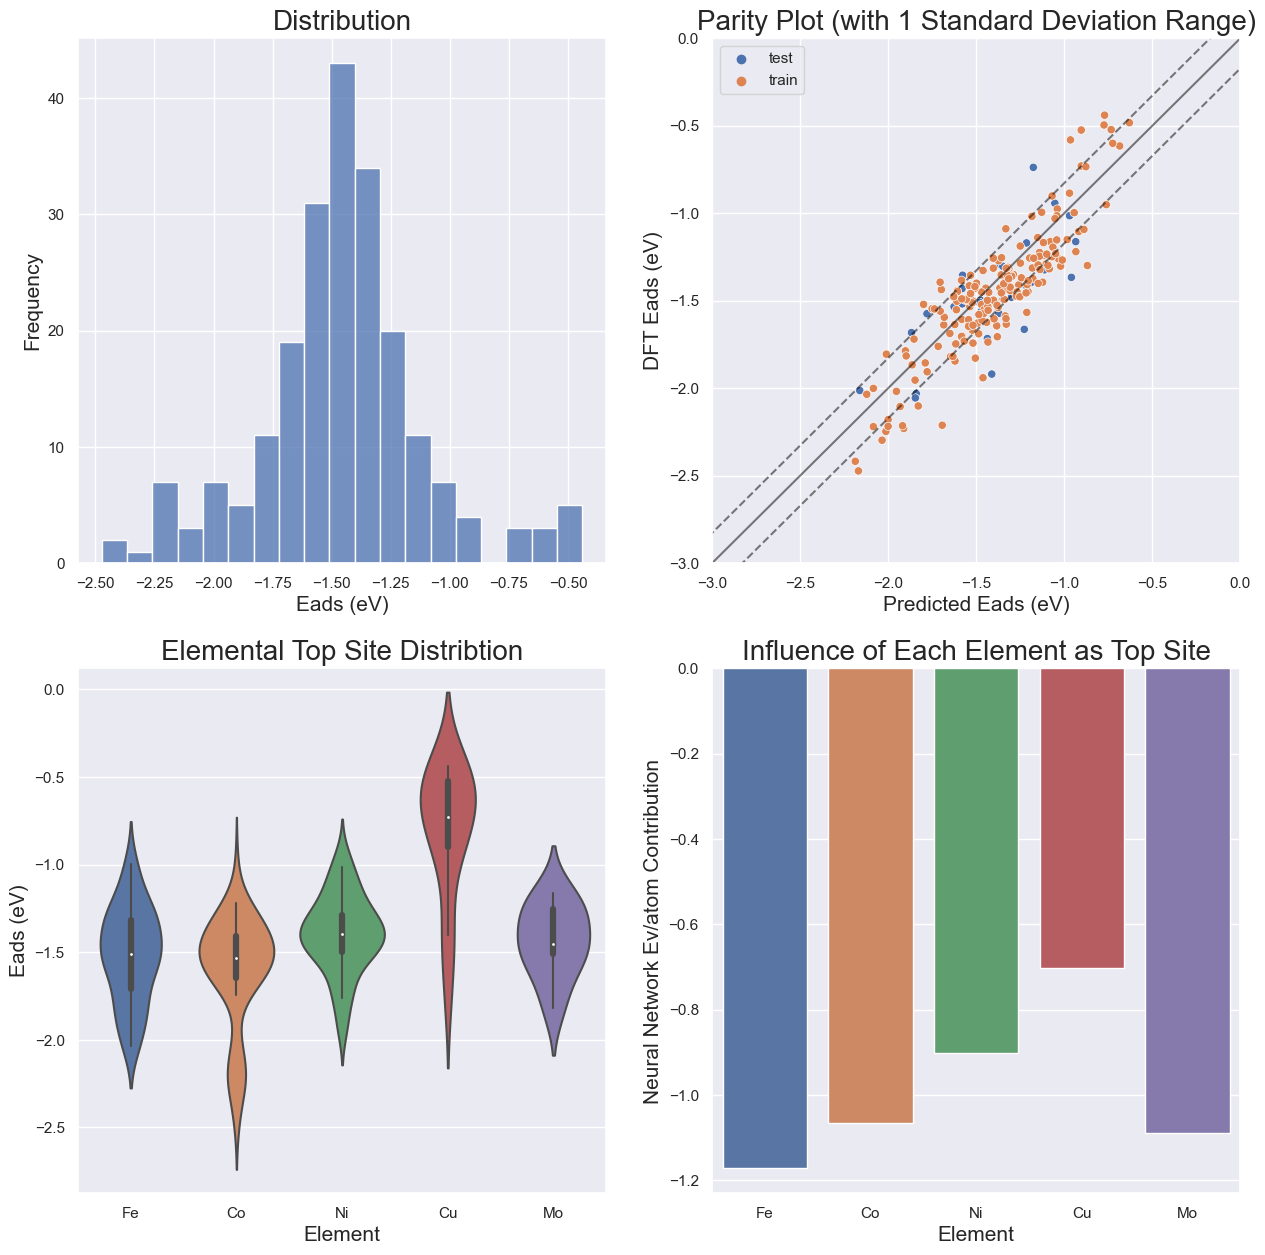

In [12]:
#Data visualization summarizing Distribution, NN performance, Element influences
sns.set_theme()
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

x1=sns.barplot(ax=axes[1, 1],x="Element", y="Ev/atom", data=vis,order=['Fe','Co','Ni','Cu','Mo'])
x1.set_xlabel("Element", fontsize = 15)
x1.set_ylabel("Neural Network Ev/atom Contribution", fontsize = 15)
x1.set_title("Influence of Each Element as Top Site", fontsize = 20)

x2=sns.violinplot(ax=axes[1, 0],x=top_df.columns[0], y="Eads", data=df_CHO,order=[ 'Fe','Co','Ni','Cu','Mo'])
x2.set_xlabel("Element", fontsize = 15)
x2.set_ylabel("Eads (eV)", fontsize = 15)
x2.set_title("Elemental Top Site Distribtion", fontsize = 20)

x3=sns.histplot(ax=axes[0, 0],data=df_CHO, x='Eads')
x3.set_xlabel("Eads (eV)", fontsize = 15)
x3.set_ylabel("Frequency", fontsize = 15)
x3.set_title("Distribution", fontsize = 20)

x4=sns.scatterplot(ax=axes[0,1],data=df, x='predict',y='real',hue='label',marker='o', color='b')
x4.set(xlim=(-3,0))
x4.set(ylim=(-3,0))
x4.plot([-4,4],[-4,4],color='black',alpha=0.5) 
x4=sns.lineplot(ax=axes[0,1],x='x',y='lines',data=df1,color='black',alpha  = 0.5)
x4.lines[1].set_linestyle("--")
x4=sns.lineplot(ax=axes[0,1],x='x',y='lines',data=df2,color='black',alpha  = 0.5)
x4.lines[2].set_linestyle("--")
x4.set_xlabel("Predicted Eads (eV)", fontsize = 15)
x4.set_ylabel("DFT Eads (eV)", fontsize = 15)
x4.set_title("Parity Plot (with 1 Standard Deviation Range)", fontsize = 20)
#plt.savefig('fig')